In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

In [185]:
MU = {
    1: [1,1],
    2: [4,3],
    3: [2,6],
    4: [7,4]
}

COV = {
    1: np.eye(2)*0.05,
    2: np.eye(2)*0.05,
    3: np.eye(2)*0.05,
    4: np.eye(2)*0.05
}

N_SAMPLERS = 4
SAMPLERS = {}
for idx in range(1, N_SAMPLERS+1, 1):
    SAMPLERS[idx] = N(MU[idx], COV[idx])

In [186]:
n = 1000
X_TRAIN, Y_TRAIN = {}, {}
X_TEST, Y_TEST = {}, {}

for cls in SAMPLERS:
    X_TRAIN[cls] = SAMPLERS[cls].sample(n)
    Y_TRAIN[cls] = np.array([cls]*n)
    X_TEST[cls] = SAMPLERS[cls].sample(n)
    Y_TEST[cls] = np.array([cls]*n)

# Dataset
def cls_to_dset(idxs, X, Y):
    x, y = [], []
    for idx in idxs:
        x.extend(X[idx])
        y.extend(Y[idx])
    x = np.array(x)
    y = np.array(y)
    return list(zip(x, y)), x, y

IND_CLS = [1, 2, 3]
OOD_CLS = [4]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)


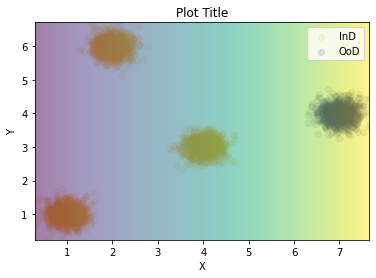

In [187]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.10)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.10)
xi = np.linspace(0, 8, 100, endpoint=True)
yi = np.linspace(0, 8, 100, endpoint=True)
# xy_pos = list(product(x_pos, y_pos))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
nbins=300
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
plt.pcolormesh(xi, yi, xi, shading='auto', alpha=0.50)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### Naive Classifier Training

In [197]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configguration
max_epoch = 64
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch)

  6%|▋         | 4/64 [00:00<00:03, 18.41it/s]

Epoch  # 1 | Tri loss: 0.9931                     | Tri accuracy: 0.6467
Epoch  # 1 | Val loss: 0.8198                     | Val accuracy: 0.8268


 20%|██        | 13/64 [00:00<00:02, 18.88it/s]

Epoch  # 11 | Tri loss: 0.0181                     | Tri accuracy: 1.0
Epoch  # 11 | Val loss: 0.0152                     | Val accuracy: 1.0


 34%|███▍      | 22/64 [00:01<00:02, 17.91it/s]

Epoch  # 21 | Tri loss: 0.0026                     | Tri accuracy: 1.0
Epoch  # 21 | Val loss: 0.0025                     | Val accuracy: 1.0


 50%|█████     | 32/64 [00:02<00:02, 13.40it/s]

Epoch  # 31 | Tri loss: 0.0011                     | Tri accuracy: 1.0
Epoch  # 31 | Val loss: 0.0011                     | Val accuracy: 1.0


 66%|██████▌   | 42/64 [00:02<00:01, 18.15it/s]

Epoch  # 41 | Tri loss: 0.0006                     | Tri accuracy: 1.0
Epoch  # 41 | Val loss: 0.0006                     | Val accuracy: 1.0


 86%|████████▌ | 55/64 [00:03<00:00, 18.48it/s]

Epoch  # 51 | Tri loss: 0.0004                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0004                     | Val accuracy: 1.0


100%|██████████| 64/64 [00:03<00:00, 17.03it/s]

Epoch  # 61 | Tri loss: 0.0003                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.0003                     | Val accuracy: 1.0


In [116]:
from wasserstein import *

torch.Size([2500, 3])


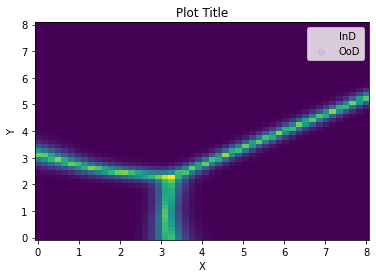

In [198]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
nbins=50
# xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)

# zi = torch.softmax(D(torch.tensor(np.vstack([xi.flatten(), yi.flatten()]).T, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)), shading='auto', alpha=1)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### WOOD Training